<a href="https://colab.research.google.com/github/Vikash-exe/Computer-Vision/blob/main/CustomB2_LISS4_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# If needed, uncomment to install deps
# !pip install -q transformers timm tifffile

import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile as tiff
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

# Colab: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
extract_dir = "/content/Dataset"   # where you want to unzip

# Make sure output dir exists
os.makedirs(extract_dir, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir}")

# Paths after extraction
images_path = os.path.join(extract_dir, "Dataset", "Images")
masks_path  = os.path.join(extract_dir, "Dataset", "Mask")

# Quick check
print("\nSample files:")
print("Images:", os.listdir(images_path)[:5])
print("Masks:", os.listdir(masks_path)[:5])


✅ Dataset extracted to: /content/Dataset

Sample files:
Images: ['Image_057.tif', 'Image_053.tif', 'Image_200.tif', 'Image_181.tif', 'Image_127.tif']
Masks: ['Mask_018.tif', 'Mask_205.tif', 'Mask_221.tif', 'Mask_016.tif', 'Mask_044.tif']


In [4]:
# Your structure:
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

import os

assert os.path.isdir(IMAGES_DIR), f"❌ Images dir not found: {IMAGES_DIR}"
assert os.path.isdir(MASKS_DIR),  f"❌ Masks dir not found: {MASKS_DIR}"

print("✅ Both Images and Masks directories found!")


✅ Both Images and Masks directories found!


In [5]:
import os

root_dir = "/content/Dataset/Dataset"  # after extraction

print("Root contents:", os.listdir(root_dir))

if "Images" in os.listdir(root_dir):
    print("Images folder contents:", os.listdir(os.path.join(root_dir, "Images"))[:10])
if "Mask" in os.listdir(root_dir):
    print("Mask folder contents:", os.listdir(os.path.join(root_dir, "Mask"))[:10])


Root contents: ['Mask', 'Images']
Images folder contents: ['Image_057.tif', 'Image_053.tif', 'Image_200.tif', 'Image_181.tif', 'Image_127.tif', 'Image_231.tif', 'Image_099.tif', 'Image_049.tif', 'Image_208.tif', 'Image_143.tif']
Mask folder contents: ['Mask_018.tif', 'Mask_205.tif', 'Mask_221.tif', 'Mask_016.tif', 'Mask_044.tif', 'Mask_069.tif', 'Mask_146.tif', 'Mask_207.tif', 'Mask_219.tif', 'Mask_222.tif']


In [6]:
# ================================
# Dataset Definition (with ID matching)
# ================================
from torch.utils.data import Dataset
from PIL import Image
import os, re
import numpy as np
import torch
from transformers import SegformerFeatureExtractor

# SegFormer processor (resize to 512x512)
processor = SegformerFeatureExtractor(do_resize=True, size=512)

def extract_number(filename):
    """Extract first number from filename, e.g. 'Image_35.tif' -> 35"""
    nums = re.findall(r'\d+', filename)
    return int(nums[0]) if nums else -1

class LULCDataset(Dataset):
    def __init__(self, image_dir, mask_dir, processor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.processor = processor

        valid_exts = ('.png', '.jpg', '.jpeg', '.tif')

        # Map files by number
        images = {extract_number(f): f for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)}
        masks  = {extract_number(f): f for f in os.listdir(mask_dir) if f.lower().endswith(valid_exts)}

        # Keep only IDs that exist in both
        common_ids = sorted(set(images.keys()) & set(masks.keys()))

        self.pairs = [(images[i], masks[i]) for i in common_ids]

        assert len(self.pairs) > 0, "❌ No matching image-mask pairs found!"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, mask_file = self.pairs[idx]

        img_path  = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # Open image (RGB) and mask (grayscale)
        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        # Apply processor (resize to 512x512)
        encoded_inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = encoded_inputs["pixel_values"].squeeze(0)  # [3, 512, 512]

        # Resize mask to 512x512 (nearest-neighbor)
        mask = mask.resize((512, 512), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.long)  # [512, 512]

        return pixel_values, mask


/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


cheching the sequence

In [7]:
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

dataset = LULCDataset(IMAGES_DIR, MASKS_DIR, processor)

print(f"✅ Dataset loaded with {len(dataset)} pairs")

# Show first 5 pairs to confirm correct matching
for i in range(5):
    img_file, mask_file = dataset.pairs[i]
    print(f"Pair {i}: {img_file}  <->  {mask_file}")


✅ Dataset loaded with 232 pairs
Pair 0: Image_001.tif  <->  Mask_001.tif
Pair 1: Image_002.tif  <->  Mask_002.tif
Pair 2: Image_003.tif  <->  Mask_003.tif
Pair 3: Image_004.tif  <->  Mask_004.tif
Pair 4: Image_005.tif  <->  Mask_005.tif


In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=512, num_classes=4, normalize=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        self.mask_files  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])

        assert len(self.image_files) == len(self.mask_files), f"Images({len(self.image_files)}) != Masks({len(self.mask_files)})"
        self.image_size = image_size
        self.num_classes = num_classes
        self.normalize = normalize
        # ImageNet mean/std (SegFormer preproc defaults)
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(3,1,1)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(3,1,1)

    def __len__(self):
        return len(self.image_files)

    def _read_image(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)          # may be float, extra dims
        else:
            arr = np.array(Image.open(path)) # HWC

        arr = np.squeeze(arr)
        # Scale non-uint8 to 0..255
        if arr.dtype != np.uint8:
            arr = (255 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)).astype(np.uint8)
        # Grayscale → RGB
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        return arr  # HWC uint8

    def _read_mask(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)
        else:
            arr = np.array(Image.open(path))
        arr = np.squeeze(arr)
        if arr.ndim == 3:
            arr = arr[:, :, 0]
        return arr  # HW (integers)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir,  self.mask_files[idx])

        # ---- Image ----
        img = self._read_image(img_path)
        img = Image.fromarray(img).resize((self.image_size, self.image_size), resample=Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0        # [0,1]
        img = np.transpose(img, (2, 0, 1))                   # C,H,W
        if self.normalize:
            img = (img - self.mean) / self.std

        # ---- Mask ----
        mask = self._read_mask(mask_path)
        mask = Image.fromarray(mask).resize((self.image_size, self.image_size), resample=Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        # Remap anything >=4 to class 3 ("Others")
        mask[mask >= self.num_classes] = self.num_classes - 1

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)


In [9]:
full_dataset = SegmentationDataset(IMAGES_DIR, MASKS_DIR, image_size=512, num_classes=4)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
xb, yb = next(iter(train_loader))
print("Batch shapes -> images:", tuple(xb.shape), "masks:", tuple(yb.shape))  # expect [B,3,512,512], [B,512,512]


Train samples: 185, Val samples: 47
Batch shapes -> images: (4, 3, 512, 512) masks: (4, 512, 512)


In [25]:
import torch
import torch.nn as nn
from transformers import SegformerModel

# === Custom SegFormer with pretrained B2 backbone ===
class CustomSegFormer(nn.Module):
    def __init__(self, num_classes=4, id2label=None, label2id=None):
        super(CustomSegFormer, self).__init__()

        # === Pretrained Encoder (B2 backbone) ===
        self.encoder = SegformerModel.from_pretrained(
            "nvidia/segformer-b2-finetuned-ade-512-512",
            output_hidden_states=True # Add this line
        )

        # B2 backbone hidden sizes
        embed_dim = [64, 128, 320, 512]
        decoder_dim = 256   # bottleneck channels for decoder

        # === Decoder Projections ===
        self.linear_c4 = nn.Conv2d(embed_dim[3], decoder_dim, kernel_size=1)
        self.linear_c3 = nn.Conv2d(embed_dim[2], decoder_dim, kernel_size=1)
        self.linear_c2 = nn.Conv2d(embed_dim[1], decoder_dim, kernel_size=1)
        self.linear_c1 = nn.Conv2d(embed_dim[0], decoder_dim, kernel_size=1)


        # Fuse and Classifier
        self.linear_fuse = nn.Conv2d(decoder_dim * 4, decoder_dim, kernel_size=1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Conv2d(decoder_dim, num_classes, kernel_size=1)


    def forward(self, pixel_values):
        # === Encoder ===
        outputs = self.encoder(pixel_values)
        hidden_states = outputs.hidden_states  # tuple of 4 stages [C1, C2, C3, C4]

        # === Reshape hidden states to [B,C,H,W] ===
        # The hidden states are already in [B, C, H, W] format, no need to reshape
        c1, c2, c3, c4 = hidden_states

        # === Decoder ===
        c1 = self.linear_c1(c1)
        c2 = self.linear_c2(c2)
        c3 = self.linear_c3(c3)
        c4 = self.linear_c4(c4)

        # Upsample to same spatial size as c1
        c2 = nn.functional.interpolate(c2, size=c1.shape[2:], mode="bilinear", align_corners=False)
        c3 = nn.functional.interpolate(c3, size=c1.shape[2:], mode="bilinear", align_corners=False)
        c4 = nn.functional.interpolate(c4, size=c1.shape[2:], mode="bilinear", align_corners=False)

        # Fuse features
        fused = torch.cat([c1, c2, c3, c4], dim=1)
        fused = self.linear_fuse(fused)
        fused = self.dropout(fused)

        # Final classifier head
        logits = self.classifier(fused)

        # Upsample back to original image resolution
        logits = nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        return logits


# === Usage ===
id2label = {0: "Urban", 1: "Water", 2: "Vegetation", 3: "Others"}
label2id = {v: k for k, v in id2label.items()}

model = CustomSegFormer(num_classes=4, id2label=id2label, label2id=label2id)
print(model)

CustomSegFormer(
  (encoder): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# id2label = {0:"Urban", 1:"Water", 2:"Vegetation", 3:"Others"}
# label2id = {v:k for k,v in id2label.items()}

# model = SegformerForSemanticSegmentation.from_pretrained(
#     "nvidia/segformer-b0-finetuned-ade-512-512",
#     num_labels=4,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,  # new head (4 classes) initialized
# )
model.to(device)

# Optim & training settings
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
num_epochs = 10


In [12]:
def pixel_accuracy(preds, labels):
    # preds: [B,H,W] (class ids), labels: [B,H,W]
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def mean_iou(preds, labels, num_classes=4):
    # preds, labels: [B,H,W]
    ious = []
    for cls in range(num_classes):
        pred_c = (preds == cls)
        label_c = (labels == cls)
        inter = (pred_c & label_c).sum().item()
        union = (pred_c | label_c).sum().item()
        if union == 0:
            ious.append(float("nan"))  # ignore if class not present in both
        else:
            ious.append(inter / union)
    return np.nanmean(ious)


In [13]:
print(f"Train samples: {len(train_dataset)} ({len(train_loader)} batches of size {BATCH_SIZE})")
print(f"Val samples:   {len(val_dataset)} ({len(val_loader)} batches of size {BATCH_SIZE})")


Train samples: 185 (47 batches of size 4)
Val samples:   47 (12 batches of size 4)


In [27]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_ious, val_ious = [], []

# Define the loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    tr_loss, tr_acc, tr_iou = 0.0, 0.0, 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        # out = model(pixel_values=imgs, labels=masks)   # CrossEntropy inside
        # loss = out.loss
        # logits = out.logits                            # [B, num_classes, H, W]

        logits = model(pixel_values=imgs)             # [B, num_classes, H, W]
        loss = criterion(logits, masks)               # Calculate loss manually

        preds = torch.argmax(logits, dim=1)            # [B,H,W]

        # Resize predictions to match mask size for metric calculation
        preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
                                                        size=masks.shape[-2:],
                                                        mode='nearest').squeeze(1).long()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        tr_acc  += pixel_accuracy(preds_resized, masks)
        tr_iou  += mean_iou(preds_resized, masks, num_classes=4)

    tr_loss /= len(train_loader)
    tr_acc  /= len(train_loader)
    tr_iou  /= len(train_loader)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    train_ious.append(tr_iou)

    # ---- Validate ----
    model.eval()
    va_loss, va_acc, va_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating"):
            imgs, masks = imgs.to(device), masks.to(device)
            # out = model(pixel_values=imgs, labels=masks)
            # va_loss += out.loss.item()
            logits = model(pixel_values=imgs)
            va_loss += criterion(logits, masks).item()


            # logits = out.logits  # Remove this line
            preds = torch.argmax(logits, dim=1)
            # Resize predictions to match mask size for metric calculation
            preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
                                                            size=masks.shape[-2:],
                                                            mode='nearest').squeeze(1).long()


            va_acc += pixel_accuracy(preds_resized, masks)
            va_iou += mean_iou(preds_resized, masks, num_classes=4)

    va_loss /= len(val_loader)
    va_acc  /= len(val_loader)
    va_iou  /= len(val_loader)

    val_losses.append(va_loss)
    val_accs.append(va_acc)
    val_ious.append(va_iou)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {tr_loss:.4f}  Val Loss: {va_loss:.4f}  |  "
          f"Train Acc: {tr_acc*100:.2f}%  Val Acc: {va_acc*100:.2f}%  |  "
          f"Train mIoU: {tr_iou:.4f}  Val mIoU: {va_iou:.4f}")

Validating: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch 1/10 | Train Loss: 0.7182  Val Loss: 0.6037  |  Train Acc: 64.53%  Val Acc: 71.01%  |  Train mIoU: 0.2856  Val mIoU: 0.3874


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 2/10 | Train Loss: 0.5791  Val Loss: 0.5502  |  Train Acc: 71.72%  Val Acc: 73.36%  |  Train mIoU: 0.4210  Val mIoU: 0.5235


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]


Epoch 3/10 | Train Loss: 0.5357  Val Loss: 0.5231  |  Train Acc: 72.94%  Val Acc: 73.65%  |  Train mIoU: 0.4756  Val mIoU: 0.5534


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]


Epoch 4/10 | Train Loss: 0.5185  Val Loss: 0.5042  |  Train Acc: 73.54%  Val Acc: 74.44%  |  Train mIoU: 0.4935  Val mIoU: 0.5632


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


Epoch 5/10 | Train Loss: 0.4985  Val Loss: 0.5537  |  Train Acc: 74.82%  Val Acc: 72.95%  |  Train mIoU: 0.5207  Val mIoU: 0.4957


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.56it/s]


Epoch 6/10 | Train Loss: 0.4936  Val Loss: 0.4937  |  Train Acc: 74.74%  Val Acc: 74.46%  |  Train mIoU: 0.5116  Val mIoU: 0.5773


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.62it/s]


Epoch 7/10 | Train Loss: 0.4697  Val Loss: 0.4848  |  Train Acc: 76.56%  Val Acc: 75.31%  |  Train mIoU: 0.5540  Val mIoU: 0.5786


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


Epoch 8/10 | Train Loss: 0.4787  Val Loss: 0.4835  |  Train Acc: 75.78%  Val Acc: 76.25%  |  Train mIoU: 0.5474  Val mIoU: 0.5912


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


Epoch 9/10 | Train Loss: 0.4662  Val Loss: 0.4932  |  Train Acc: 76.52%  Val Acc: 74.56%  |  Train mIoU: 0.5487  Val mIoU: 0.5690


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.65it/s]

Epoch 10/10 | Train Loss: 0.4682  Val Loss: 0.4791  |  Train Acc: 76.55%  Val Acc: 76.09%  |  Train mIoU: 0.5398  Val mIoU: 0.5884


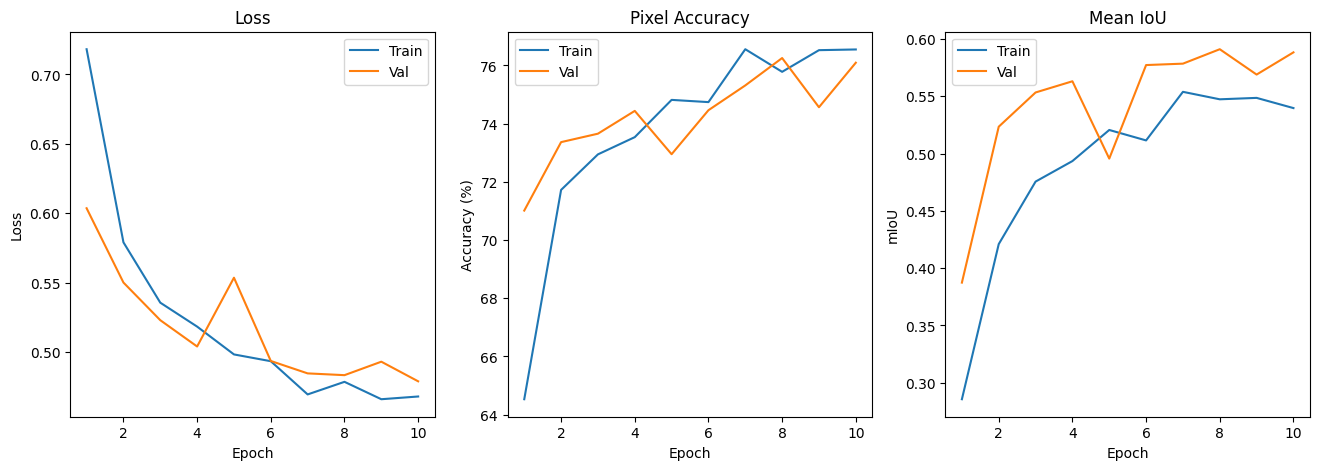

In [28]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses, label="Val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, [a*100 for a in train_accs], label="Train")
plt.plot(epochs, [a*100 for a in val_accs], label="Val")
plt.title("Pixel Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, train_ious, label="Train")
plt.plot(epochs, val_ious, label="Val")
plt.title("Mean IoU"); plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.legend()

plt.show()


Calling the trained model

In [ ]:
# from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# # Path where you saved earlier
# load_dir = "/content/drive/MyDrive/segformer_lulc"

# # Load trained model + processor
# model = SegformerForSemanticSegmentation.from_pretrained(load_dir)
# processor = SegformerFeatureExtractor.from_pretrained(load_dir)

# print("✅ Trained model and processor loaded successfully!")


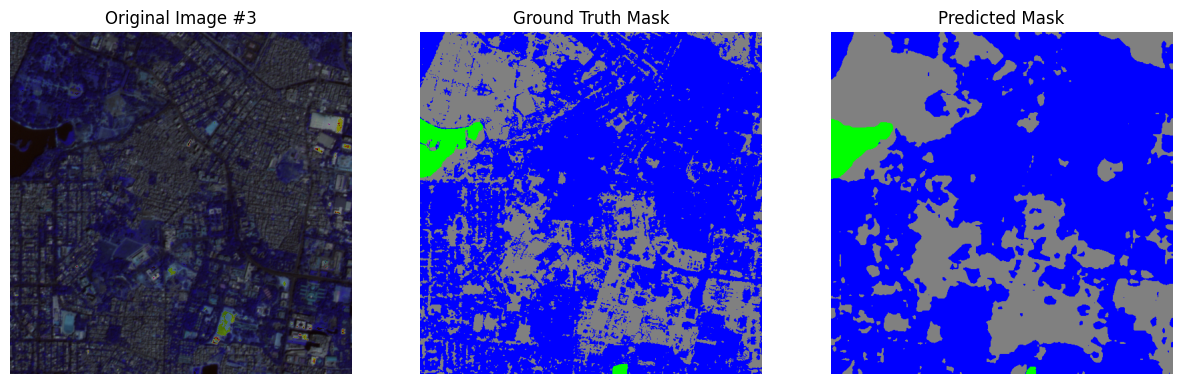

In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

# Color map for 4 classes
COLOR_MAP = {
    0: (255, 0, 0),     # Urban -> Red
    1: (0, 0, 255),     # Water -> Blue
    2: (0, 255, 0),     # Vegetation -> Green
    3: (128, 128, 128)  # Others -> Gray
}

def decode_color(mask_np):
    """Map class indices to RGB colors for visualization"""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLOR_MAP.items():
        rgb[mask_np == cls] = color
    return rgb

# -------------------------------
# Inference for a specific index
# -------------------------------
model.eval()
idx = 3   # <-- choose any index here

# Make sure dataset returns correct pair
img, true_mask = val_dataset[idx]   # img: [3,512,512], true_mask: [512,512]
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=img_batch)
    pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Changed outputs.logits to outputs

# Convert tensors back for visualization
true_mask = true_mask.cpu().numpy()
img_vis = img.cpu().numpy()

# Undo normalization for display
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
img_vis = (img_vis * std + mean).clip(0,1)
img_vis = np.transpose(img_vis, (1,2,0))  # CHW -> HWC

# -------------------------------
# Show results
# -------------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_vis); plt.title(f"Original Image #{idx}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(decode_color(true_mask)); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(decode_color(pred_mask)); plt.title("Predicted Mask"); plt.axis("off")
plt.show()

In [32]:
save_dir = "/content/drive/MyDrive/CustomB2_segformer_lulc"

import os
import torch
os.makedirs(save_dir, exist_ok=True)

# Save trained model state dictionary
torch.save(model.state_dict(), os.path.join(save_dir, 'model_state_dict.pth'))

# The custom model doesn't have a save_pretrained method for the processor.
# If you were using the Hugging Face SegformerForSemanticSegmentation, you would save the processor like this:
# processor.save_pretrained(save_dir)

print(f"✅ Model state dictionary saved to {os.path.join(save_dir, 'model_state_dict.pth')}")

✅ Model state dictionary saved to /content/drive/MyDrive/CustomB2_segformer_lulc/model_state_dict.pth
